In [89]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.externals.six import StringIO 
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer
import sklearn
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import decomposition
from sklearn.model_selection import cross_val_score

# XGBoost
import xgboost as xgb

# Pandas
import pandas as pd

# Numpy
import numpy as np
# Set random seed
np.random.seed(0)

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus

In [90]:
df = pd.read_csv('KeplerData.csv')
df.head()

,rowid,kepid,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,1,10797460,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,2,10797460,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,3,10811496,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,19.899140,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,4,10848459,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,5,10854555,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200


In [91]:
# remove canidates (2244 rows)
target = 'koi_disposition'
df = df[df[target] != 'CANDIDATE']
# can't include these columns because they are all null
#invalids = ['Equilibrium Temperature Upper Uncertainty [K]', 'Equilibrium Temperature Lower Uncertainty [K]']
# these are all the features
features = list(set(df.columns[4:]) - set(invalids))
data = df[features + [target]]
# dropping any rows with na drops another 2538 rows
withoutna = data.dropna()
len(withoutna)

4997

In [103]:
train, test = sklearn.model_selection.train_test_split(withoutna)
y_train = train[target]
X_train = train[features]
y_test = test[target]
X_test = test[features]
# X_train, X_test, y_train, y_test = \
#     train_test_split(features, target, test_size=.4, random_state=42)

In [104]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

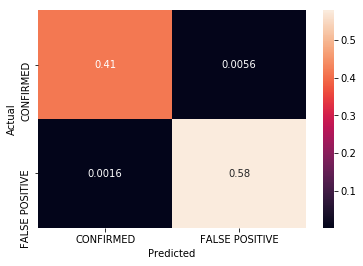

In [105]:
confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], normalize=True)
sns.heatmap(confusion, annot=True)

In [106]:
cv_scores_rf = cross_val_score(clf, X_test, y_test, cv=5)

print("Accuracy:\t\t", np.mean(cv_scores_rf))
print("Completeness:\t\t", sklearn.metrics.recall_score(y_test, y_pred, average='micro'))
print("Contamination:\t\t", 1 - sklearn.metrics.precision_score(y_test, y_pred, average='micro'))

Accuracy:		 0.984
Completeness:		 0.9928
Contamination:		 0.007199999999999984


['koi_score',
 'koi_dikco_msky',
 'koi_ror',
 'koi_fpflag_ss',
 'koi_count',
 'koi_fpflag_co',
 'koi_fpflag_nt',
 'koi_dor',
 'koi_fwm_stat_sig',
 'koi_prad',
 'koi_srad']

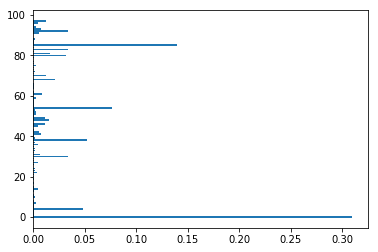

In [107]:
values = list(zip(features, clf.feature_importances_))
plt.barh(range(len(clf.feature_importances_)), [x[1] for x in values])
sortd = sorted(values, reverse = True, key= lambda x: x[1])[:20]
most_important = [s[0] for s in sortd if 'err' not in s[0]]
# we dont want any features which have 'Uncertainty'
#most_important = [x for x in most_important if 'Uncertainty' not in x]
#most_important
most_important

koi_score                                                 
                    count      mean       std  min    25%  50%  75%    max
koi_disposition                                                           
CONFIRMED          2285.0  0.962631  0.144378  0.0  0.993  1.0  1.0  1.000
FALSE POSITIVE     3976.0  0.014899  0.062409  0.0  0.000  0.0  0.0  0.957

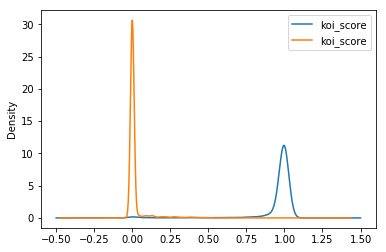

In [108]:
# here we look at the most important feature
fig, axs = plt.subplots(ncols=1)
data = df[['koi_score', target]]
data.groupby(target).plot(kind='kde', ax=axs)
data.groupby(target).describe()

Accuracy:		 0.9831870717931487
Completeness:		 0.9872
Contamination:		 0.012800000000000034


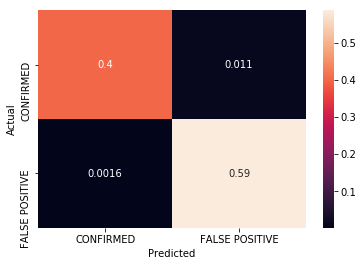

In [109]:
# Rerun using only the top 10 most important features
important = withoutna[most_important + [target]]
train, test = sklearn.model_selection.train_test_split(important)
y_train = train[target]
X_train = train[most_important]
y_test = test[target]
X_test = test[most_important]
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], normalize=True)
sns.heatmap(confusion, annot=True)
cv_scores_rf = cross_val_score(clf, X_test, y_test, cv=5)

print("Accuracy:\t\t", np.mean(cv_scores_rf))
print("Completeness:\t\t", sklearn.metrics.recall_score(y_test, y_pred, average='micro'))
print("Contamination:\t\t", 1 - sklearn.metrics.precision_score(y_test, y_pred, average='micro'))

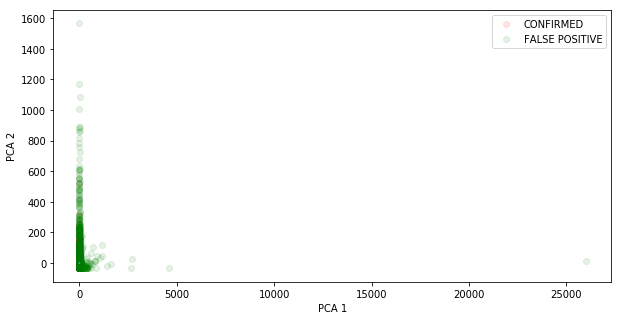

In [110]:
iris = np.array(withoutna[most_important])
species = withoutna[target]
iris_colors = {'FALSE POSITIVE': 'g', 'CONFIRMED': 'r'}

pca = decomposition.PCA(n_components=2)
pca.fit(iris)
iris_pca = pca.transform(iris)

# projected coordinates
fig, ax = plt.subplots(figsize = (10, 5))
for specie in np.unique(species):
    mask = (species == specie)
    ax.scatter(iris_pca[mask][:, 0], iris_pca[mask][:, 1], label = specie, c = iris_colors[specie], alpha = 0.1)

# loading vectors
eviris = 2. * pca.components_
for idx, var in enumerate(most_important[:-1]):
    ax.plot([0, eviris[0, idx]], [0, eviris[1, idx]])
    #ax.text(eviris[0, idx], eviris[1, idx], var)
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.legend();

In [116]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    #SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

# preprocess dataset, split into training and test part
X, y = withoutna[most_important], withoutna[target]
#X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.4, random_state=42)

In [117]:
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cv_scores_rf = cross_val_score(clf, X_test, y_test, cv=5)
    print(name)
    print("Accuracy:\t\t", np.mean(cv_scores_rf))
    print("Completeness:\t\t", sklearn.metrics.recall_score(y_test, y_pred, average='micro'))
    print("Contamination:\t\t", 1 - sklearn.metrics.precision_score(y_test, y_pred, average='micro'))
    print('\n\n')

Nearest Neighbors
Accuracy:		 0.9474774436090225
Completeness:		 0.9459729864932466
Contamination:		 0.05402701350675343



Linear SVM
Accuracy:		 0.8144160401002505
Completeness:		 0.8429214607303652
Contamination:		 0.15707853926963478



RBF SVM
Accuracy:		 0.9899924812030075
Completeness:		 0.9884942471235618
Contamination:		 0.01150575287643818



Gaussian Process
Accuracy:		 0.9899924812030075
Completeness:		 0.9824912456228114
Contamination:		 0.017508754377188573



Decision Tree
Accuracy:		 0.9864937343358398
Completeness:		 0.9889944972486243
Contamination:		 0.011005502751375684



Random Forest
Accuracy:		 0.9859899749373433
Completeness:		 0.991495747873937
Contamination:		 0.008504252126062983



Neural Net
Accuracy:		 0.9884924812030075
Completeness:		 0.9894947473736868
Contamination:		 0.010505252626313188



AdaBoost
Accuracy:		 0.9889924812030075
Completeness:		 0.9889944972486243
Contamination:		 0.011005502751375684



